In [25]:
import pandas
import pandas as pd
import os
import numpy as np
import cv2
import imutils
from shapely.geometry import shape, GeometryCollection,Polygon,mapping
import json
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from PIL import Image
from sklearn.utils.multiclass import type_of_target

from tqdm import tqdm


In [3]:
#open manual annotated image from geojson (exported qupath image as geojason because paquo installation failed)
src = r'\\fatherserverdw\Q\research\images\skin_aging\hovernet_tile\hovernet_manual_validation'
manual = os.path.join(src,'manual_annotation')
predicted = os.path.join(src,'predicted_nuclei_contour')
raw_ims = os.path.join(src,'raw_image')

#open manual annotations with json.load
annotations = glob.glob(os.path.join(manual,'*.geojson'))
#load ashley_test to try
annotation = annotations[1]
with open(annotation) as f:
  features = json.load(f)["features"]


In [4]:
#get size of origianl image
raw = glob.glob(os.path.join(raw_ims,'*.tif'))
raw_img = cv2.imread(raw[0])
dim = raw_img.shape
image_size = (dim[0],dim[1])

In [5]:
#open predicted annotations
pd_annotations = glob.glob(os.path.join(predicted,'*.json'))
#open tile11
pd_annotation = pd_annotations[0]
with open(pd_annotation) as pd_f:
  #bbox, centroid, contour
  pd_features = json.load(pd_f)["nuc"]

In [6]:
#create a list of predicted contours
pd_contours=[]
for key in pd_features:
    contour = []
    temp = pd_features.get(key)
    #for c in temp.get('contour'):#turn list to tuple
        #contour.append(tuple(c))
    pd_contours.append(temp.get('contour'))

In [7]:
#TODO:
#convert predicted contours to shapely polygons, then from polygons to coordinates

#create a list of predicted shapely polygons
#pd_poly = [Polygon(x) for x in pd_contours]

In [8]:
#create a list of predicted binary masks
pd_masks = []
for contour in pd_contours:
    image = np.zeros(image_size)
    binary = cv2.fillPoly(image, pts=[np.array(contour)],  color=(1, 0, 0))
    pd_masks.append(binary)

In [9]:
#is this the contour of manual coordinates?
#something/wrong with the manual data: 1.some idx are in float64, 2.some have multiple obj in one idx ([101])
man_coordinates = [np.squeeze(_['geometry']['coordinates']) for _ in features]

In [10]:
#create a list of manually annotated binary masks
man_masks=[]
for coord in man_coordinates:
    image = np.zeros(image_size)
    binary = cv2.fillPoly(image, pts=[np.array(coord).astype(np.int32)],  color=(1, 0, 0))
    man_masks.append(binary)

In [18]:
#type check
#continous-multi output is a 2d array of floats that are not all integers, and both dimensions are of size > 1.
type_of_target(pd_masks[109])

'multilabel-indicator'

In [20]:
#'multilabel-indicator': is a label indicator matrix, an array of two dimensions with at least two columns, and at most 2 unique values.
type_of_target(pd_masks[108])

'multilabel-indicator'

In [28]:
#test for just one manual, works
match = pd_masks[0]
score = jaccard_score(man_masks[0], pd_masks[0], average="micro")
for pd in tqdm(pd_masks):
    if(jaccard_score(man_masks[0], pd, average="micro") > score):
        match = pd
        score = jaccard_score(man_masks[0], pd, average="micro")

100%|██████████| 347/347 [00:30<00:00, 11.23it/s]


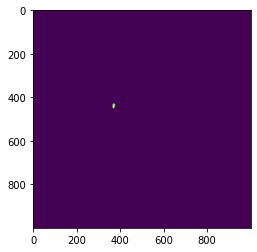

In [30]:
plt.imshow(match)

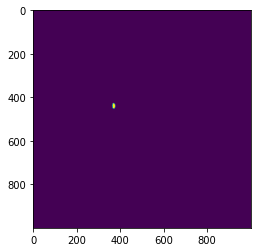

In [32]:
plt.imshow(man_masks[0])

In [43]:
#create a empty dataframe to store nuclei mappings
col_names = ["manual","predicted","score"]
nuc_map = pd.DataFrame(columns=col_names)


In [49]:

#question: is micro the right average?
#also, since it's not a one-one mapping, we need to consider cases where there is no match
#what's more, are we mapping predicted masks to manual masks? does the order matter?
thres = 0.7
#loop through manual masks
for man in tqdm(man_masks):
    #initialize variables
    match = None
    score = jaccard_score(man_masks[0], pd_masks[0], average="micro")

    #loop through predicted masks
    for pd in pd_masks:
        if(jaccard_score(man, pd, average="micro") > score):
            match = pd
            score = jaccard_score(man, pd, average="micro")
    #add match and score to df
    #thres probaly is not the best way to solve the no match situation, i don;t know how to
    if(score > thres):
        df2 = {'manual': man, 'predicted': pd, 'score': score}
        nuc_map = nuc_map.concat(df2, ignore_index = True)
    else:
         df2 = {'manual': man, 'predicted': None, 'score': score}
         nuc_map= nuc_map.concat(df2, ignore_index = True)

  0%|          | 0/384 [00:30<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'concat'

In [ ]:
#----old code-----

In [45]:
#calculate centroid through contour
def cntcent(cnt):
    M = cv2.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return [cX,cY]

#function that calculates area based on contour
#parameter cnt: contour
#return: area
def cntarea(cnt):
    cnt = np.array(cnt)
    try:
        area = cv2.contourArea(cnt)
    except:
        area = cv2.contourArea(cnt+1)
    return area

In [48]:
cent = np.zeros((len(man_coordinates_arr),2))
areas = np.zeros((len(man_coordinates_arr),1))
for idx,arr in enumerate(man_coordinates_arr):
    [cx,cy]=cntcent(arr)
    contours = arr[0] if imutils.is_cv2() else arr[1]
    areas[idx] = cntarea(arr)
    cent[idx,:] = cx,cy

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:315: error: (-215:Assertion failed) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::contourArea'


In [42]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(cent) #build model
distances, indices = nbrs.kneighbors(cent) #query point

In [45]:
distance = distances[:, 1]
distance

array([19.02629759, 28.46049894, 23.43074903, 29.41088234, 21.02379604,
       24.20743687, 28.01785145, 28.65309756, 21.1896201 , 21.02379604,
       21.02379604, 22.47220505, 22.47220505, 24.75883681, 18.68154169,
       18.68154169, 21.84032967, 13.41640786, 13.41640786, 17.69180601,
       17.69180601, 25.17935662, 16.4924225 , 22.09072203, 17.08800749,
       22.09072203, 24.04163056, 24.75883681, 21.09502311, 21.09502311,
       20.61552813, 18.02775638, 21.58703314, 19.72308292, 14.        ,
       14.        , 25.61249695, 17.02938637, 15.23154621, 20.51828453,
       17.02938637, 17.4642492 , 16.64331698, 26.2488095 , 18.86796226,
       19.92485885, 16.2788206 , 15.        , 24.04163056, 15.        ,
       12.20655562, 21.26029163, 21.9544984 , 18.60107524, 27.73084925,
       31.82766093, 20.61552813, 23.32380758, 26.17250466, 18.86796226,
       18.86796226, 21.26029163, 22.02271555, 19.6977156 , 19.6977156 ,
       16.64331698, 17.4642492 , 24.69817807, 24.69817807, 26.47

In [28]:
#open hovernet image
src = r'\\fatherserverdw\Q\research\images\skin_aging\hovernet_tile\TILE\imID_8_sec_1\out\json'
fn = '11.json'

In [29]:
json = pd.read_json(os.path.join(src,fn),orient='records')

In [30]:
centroid = [_['centroid'] for _ in json.nuc]
contour = [_['contour'] for _ in json.nuc]
bbox = [_['bbox'] for _ in json.nuc]

In [17]:
#hovernet image dataframe
df = pd.DataFrame({'centroid':centroid,'contour':contour,'bbox':bbox})

In [18]:
#add area to hovernet dataframe
df['Area'] = df['contour'].apply(lambda row: cntarea(row))

In [35]:
#calculate centroid for manual annotation

#for each centroid from manual annotation, find nearest centroid in hovernet

In [ ]:
#compare hovernet contour (df) and manual annotation coordinates
#i.e. compare the centriods from hovernet and manual
#does order matter? training vs.target?
X = [[0], [1], [2], [3]] #training set
y = [0, 0, 1, 1] #target set
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X, y)
# all above is to create a map of centroid using X,y which is centroid in manual annotation

centroid_ID = []
for x,y in hovernet_centroids:
    centroid_ID.append(neigh.predict([x,y])) # predict function requires query point which is centroid in hovernet predict contour's centroid


In [ ]:
#IoU: area of overlap/area of union
#python compute_stats.py --mode=instance --pred_dir='pred_dir' --true_dir='true_dir'